In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import dlib
import imutils
from imutils import face_utils
from scipy.spatial import distance as dist
from skimage import draw

%matplotlib inline
datadir = "data"

In [2]:
FACIAL_LANDMARK_PREDICTOR = "models/shape_predictor.dat"  
MINIMUM_EAR = 0.2
MAXIMUM_FRAME_COUNT = 10

In [3]:
faceDetector = dlib.get_frontal_face_detector()
landmarkFinder = dlib.shape_predictor(FACIAL_LANDMARK_PREDICTOR)

In [4]:
(leftEyeStart, leftEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rightEyeStart, rightEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

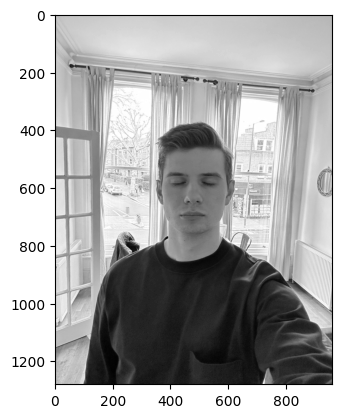

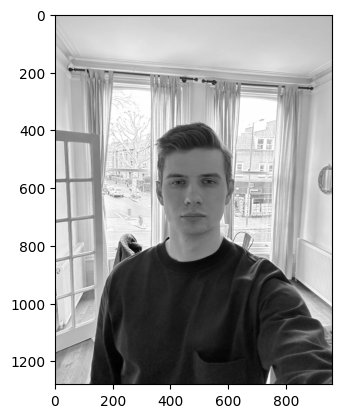

In [5]:
closed_image = cv2.cvtColor(cv2.imread(datadir+'/paired/2/closed.jpeg'), cv2.COLOR_RGB2GRAY)
plt.imshow(closed_image, cmap="gray")
plt.show()

open_image = cv2.cvtColor(cv2.imread(datadir+'/paired/2/open.jpeg'), cv2.COLOR_RGB2GRAY)
plt.imshow(open_image, cmap="gray")
plt.show()

images = [closed_image, open_image]

In [6]:
def eye_aspect_ratio(eye):
    p2_minus_p6 = dist.euclidean(eye[1], eye[5])
    p3_minus_p5 = dist.euclidean(eye[2], eye[4])
    p1_minus_p4 = dist.euclidean(eye[0], eye[3])
    ear = (p2_minus_p6 + p3_minus_p5) / (2.0 * p1_minus_p4)
    return ear

def centroid(eye):
    return int(sum(eye[:, 0] / len(eye[:, ]))), int(sum(eye[:, 1] / len(eye[:, ])))

eyes = []
for image in images:
    faces = faceDetector(image, 0)
    # For now only support if and only if there is one face in the image.
    assert(len(faces) == 1)
    faceLandmarks = landmarkFinder(image, faces[0])
    faceLandmarks = face_utils.shape_to_np(faceLandmarks)
    leftEye = faceLandmarks[leftEyeStart:leftEyeEnd]
    rightEye = faceLandmarks[rightEyeStart:rightEyeEnd]
    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)
    eyes.append([
        {
            "kind": "left",
            "EAR": leftEAR,
            "status": "closed" if leftEAR < MINIMUM_EAR else "open",
            "centroid": centroid(leftEye),
            "coordinates": leftEye,
        },
        {
            "kind": "right",
            "EAR": rightEAR,
            "status": "closed" if rightEAR < MINIMUM_EAR else "open",
            "centroid": centroid(rightEye),
            "coordinates": rightEye,
        },
    ])
    
print(eyes)

[[{'kind': 'left', 'EAR': 0.15364425591947517, 'status': 'closed', 'centroid': (528, 589), 'coordinates': array([[509, 588],
       [522, 586],
       [535, 587],
       [548, 590],
       [535, 593],
       [522, 592]])}, {'kind': 'right', 'EAR': 0.17925163190605437, 'status': 'closed', 'centroid': (428, 589), 'coordinates': array([[410, 590],
       [422, 586],
       [435, 585],
       [449, 588],
       [435, 592],
       [422, 593]])}], [{'kind': 'left', 'EAR': 0.29777679693534087, 'status': 'open', 'centroid': (530, 581), 'coordinates': array([[509, 584],
       [522, 575],
       [538, 575],
       [551, 582],
       [538, 588],
       [523, 587]])}, {'kind': 'right', 'EAR': 0.2926829268292683, 'status': 'open', 'centroid': (426, 584), 'coordinates': array([[407, 586],
       [419, 579],
       [434, 577],
       [448, 586],
       [434, 590],
       [419, 590]])}]]


In [35]:
# TODO: finish replacement & blending

# The first image is always the target, for now.
target_image = cv2.cvtColor(cv2.imread(datadir+'/paired/2/closed.jpeg'), cv2.COLOR_RGB2GRAY)
source_image = cv2.cvtColor(cv2.imread(datadir+'/paired/2/open.jpeg'), cv2.COLOR_RGB2GRAY)
target_eyes = eyes[0]
left_target_eye = target_eyes[0]
if left_target_eye['status'] == 'closed':
    for eye_pairs in eyes[1:]:
        left_eye = eye_pairs[0]
        if left_eye['status'] == 'open':
            # For now assume both target and source image are the same shape,
            # but really this should be source image shape.
            vertex_row_coords = [z[0] for z in left_eye['coordinates']]
            vertex_col_coords = [z[1] for z in left_eye['coordinates']]
            fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, target_image.shape)
            mask = np.zeros(target_image.shape, dtype=np.uint8)
            mask[fill_row_coords, fill_col_coords] = 1
            cv2.seamlessClone(source_image, target_image, mask, left_target_eye["centroid"], cv2.NORMAL_CLONE)

# plt.imshow(target_image, cmap="gray")
# plt.show()    

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/deriv.cpp:792: error: (-215:Assertion failed) !_src.empty() in function 'Laplacian'
